# Indian Classical Dance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import cv2
from scipy import stats
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras import Sequential
from keras.models import Model
from keras.layers import Dense, Flatten, Conv2D, Dropout
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
np.random.seed(0)
import keras.backend as K
data_location = '/Users/anishphilljoe/Desktop/ClassifyDance/data/'

In [1]:
import tensorflow

## 1. Read data from files

In [3]:
train_data = pd.read_csv(data_location+'train.csv')
test_data = pd.read_csv(data_location+'test.csv')

FileNotFoundError: [Errno 2] File /Users/anishphilljoe/Desktop/ClassifyDance/data/train.csv does not exist: '/Users/anishphilljoe/Desktop/ClassifyDance/data/train.csv'

In [ ]:
train_img_name_label = np.array(train_data[['Image','target']])
test_img_name = np.array(test_data['Image'])

### 1.1 Image Augmentation

In [4]:
datagen = ImageDataGenerator( 
        rotation_range = 40, 
        shear_range = 0.2, 
        zoom_range = 0.2, 
        horizontal_flip = True, 
        brightness_range = (0.5, 1.5)) 

In [5]:
train_x = []
train_y = []
test_x = []
test_y = []
for img, target in train_img_name_label:

    image = load_img(data_location+'train/'+img)
    x,y,z = np.array(image).shape
    train_x.append(x)
    train_y.append(y)
    
for img in test_img_name:

    image = load_img(data_location+'test/'+img)
    x,y,z = np.array(image).shape
    test_x.append(x)
    test_y.append(y)

(0, 500)

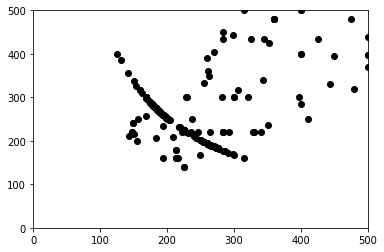

In [6]:
plt.plot(train_x, train_y, 'o', color='black')
plt.xlim(0, 500)
plt.ylim(0, 500)

(0, 500)

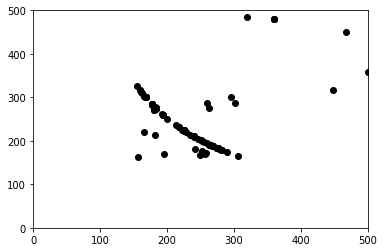

In [7]:
plt.plot(test_x, test_y, 'o', color='black')
plt.xlim(0, 500)
plt.ylim(0, 500)

In [8]:
train = []
for img, target in train_img_name_label:

    image = load_img(data_location+'train/'+img, target_size = (224,224))
    train.append([np.array(image), target])
    #1. Original Image
    x = np.array(image).reshape(1,224,224,3)
    
    #1.1 Generate 4 augmented image from original image
    aug_iter = datagen.flow(x.reshape(1,224,224,3))
    aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(5)]
    for i in range(5):
        train.append([aug_images[i], target])

    #2. Mirror of original image
    image = ImageOps.mirror(image)
    train.append([np.array(image), target])
        
    x = np.array(image).reshape(1,224,224,3)
    
    #2.1 Generate 3 augmented image out of mirror image of original image
    aug_iter = datagen.flow(x.reshape(1,224,224,3))
    aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(5)]
    for i in range(5):
        train.append([aug_images[i], target])

In [9]:
#Generate test image np array
test = []
for img in test_img_name:
    image = load_img(data_location+'test/'+img, target_size = (224,224))
    test.append(np.array(image))

In [10]:
train_df = pd.DataFrame(train, columns = ['image', 'target'])
#test_df = pd.DataFrame(train, columns = ['image'])

In [11]:
train_df['image'].shape

(4368,)

In [12]:
np.array(test).shape

(156, 224, 224, 3)

### 1.2 Let's look at top 50 images

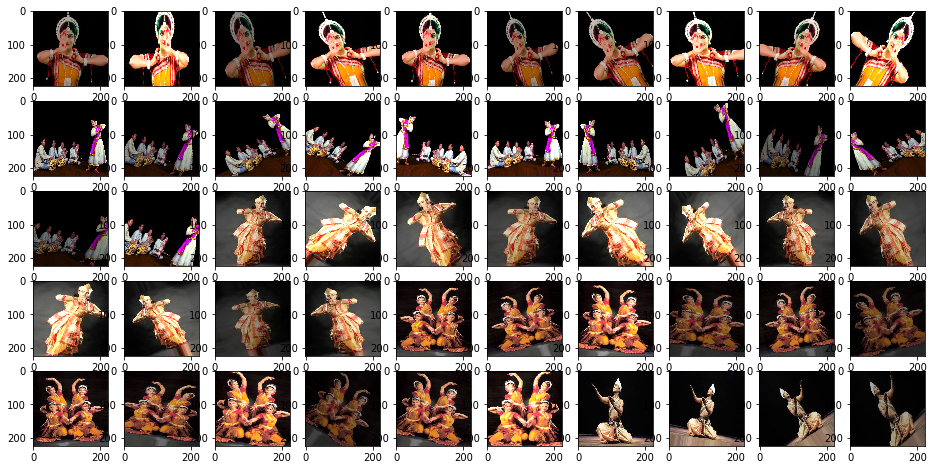

In [13]:
train_image = np.array(train_df[['image']])
plt.figure(figsize=(16,8))
count = 0
for img in train_image[50:100]:
    count = count + 1
    plt.subplot(5,10,count)
    plt.imshow(img[0])
plt.show()

## 2. Preprocess the image and labels

In [14]:
train_image1 = np.array([preprocess_input(i[0].reshape((1, i[0].shape[0], i[0].shape[1], i[0].shape[2]))) 
                        for i in np.array(train_df[['image']])])
train_image = np.array([preprocess_input(i[0].reshape((i[0].shape[0], i[0].shape[1], i[0].shape[2]))) 
                        for i in np.array(train_df[['image']])])
train_image_target = np.array([i for i in np.array(train_df[['target']])])

In [15]:
columnTransformer = ColumnTransformer([('encoder', 
                                        OneHotEncoder(), 
                                        [0])], 
                                      remainder='passthrough') 
  
train_label = np.array(columnTransformer.fit_transform(train_image_target).todense())

In [16]:
label_lookup = [i.split('_')[3] for i in columnTransformer.get_feature_names()]
label_lookup

['bharatanatyam',
 'kathak',
 'kathakali',
 'kuchipudi',
 'manipuri',
 'mohiniyattam',
 'odissi',
 'sattriya']

In [17]:
train_image.shape, train_label.shape

((4368, 224, 224, 3), (4368, 8))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(train_image, train_label, test_size=0.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3057, 224, 224, 3) (3057, 8)
(1311, 224, 224, 3) (1311, 8)


### 2. Load and run VGG6 model

In [15]:
model = VGG16()
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### 2.1 Predict 50 image category from 1000 image net classes

In [16]:
yhat = []
for i in train_image1[:50]:
    yhat.append(model.predict(i))

In [17]:
label = [decode_predictions(i)[0][0][1] for i in yhat]

In [18]:
list(zip(label,train_image_target[:50]))

[('mosquito_net', array(['manipuri'], dtype=object)),
 ('mosquito_net', array(['manipuri'], dtype=object)),
 ('mosquito_net', array(['manipuri'], dtype=object)),
 ('mosquito_net', array(['manipuri'], dtype=object)),
 ('mosquito_net', array(['manipuri'], dtype=object)),
 ('mosquito_net', array(['manipuri'], dtype=object)),
 ('mosquito_net', array(['manipuri'], dtype=object)),
 ('mosquito_net', array(['manipuri'], dtype=object)),
 ('mosquito_net', array(['manipuri'], dtype=object)),
 ('mosquito_net', array(['manipuri'], dtype=object)),
 ('mosquito_net', array(['manipuri'], dtype=object)),
 ('mosquito_net', array(['manipuri'], dtype=object)),
 ('mosquito_net', array(['bharatanatyam'], dtype=object)),
 ('mosquito_net', array(['bharatanatyam'], dtype=object)),
 ('mosquito_net', array(['bharatanatyam'], dtype=object)),
 ('mosquito_net', array(['bharatanatyam'], dtype=object)),
 ('mosquito_net', array(['bharatanatyam'], dtype=object)),
 ('mosquito_net', array(['bharatanatyam'], dtype=object))

In [19]:
train_image1=None

## 3. Fine tuning (VGG16)

### 3.1 Define the model

In [376]:
model = VGG16(include_top=False, input_shape=(224, 224, 3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False

In [377]:
flat1 = Flatten()(model.outputs[0])
class1 = Dense(512, activation='relu')(flat1)
drop = Dropout(0.3)(class1)
class2 = Dense(256, activation='relu')(drop)
output = Dense(8, activation='sigmoid')(class2)
model = Model(inputs=model.inputs, outputs=output)

In [378]:
model = Model(inputs=model.inputs, outputs=model.layers[-1].output)

In [379]:
model.summary()

Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

### 3.2 Train the model

In [24]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [25]:
#epochs
e = 3
history = model.fit(X_train, y_train, batch_size = 64, epochs=e, validation_split = 0.1, verbose=1)

Epoch 1/3
50/50 [==============================] - 935s 19s/step - loss: 0.3402 - accuracy: 0.5461 - val_loss: 0.0800 - val_accuracy: 0.9314
Epoch 2/3
50/50 [==============================] - 930s 19s/step - loss: 0.0496 - accuracy: 0.9660 - val_loss: 0.0211 - val_accuracy: 0.9800
Epoch 3/3
50/50 [==============================] - 935s 19s/step - loss: 0.0134 - accuracy: 0.9955 - val_loss: 0.0121 - val_accuracy: 0.9857


In [26]:
result = model.predict(X_test)

In [27]:
test_label = np.zeros(1168).reshape(146,8)
for i in range(len(test_label)):
    test_label[i][result[i].argmax()] = 1
count = 0
for i in range(len(y_test)):
    if result[i].argmax() == y_test[i].argmax():
        count = count + 1
print(count/len(y_test))

0.9931350114416476


### 3.3 Amonther model with F1-score as metric

In [29]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [107]:
model1 = VGG16(include_top=False, input_shape=(224, 224, 3))
# mark loaded layers as not trainable
for layer in model1.layers:
    layer.trainable = False
flat1 = Flatten()(model1.outputs[0])
class1 = Dense(512, activation='relu')(flat1)
drop = Dropout(0.3)(class1)
output = Dense(8, activation='sigmoid')(drop)
model1 = Model(inputs=model1.inputs, outputs=output)

In [108]:
model1 = Model(inputs=model1.inputs, outputs=model1.layers[-1].output)
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=[get_f1])

In [109]:
#epochs
e = 3
history = model1.fit(X_train, y_train, epochs=e, batch_size = 128, validation_split = 0.2, verbose=1)

Epoch 1/3
22/22 [==============================] - 947s 43s/step - loss: 0.6475 - get_f1: 0.4263 - val_loss: 0.1305 - val_get_f1: 0.7974
Epoch 2/3
22/22 [==============================] - 894s 41s/step - loss: 0.0854 - get_f1: 0.8791 - val_loss: 0.0426 - val_get_f1: 0.9540
Epoch 3/3
22/22 [==============================] - 890s 40s/step - loss: 0.0330 - get_f1: 0.9691 - val_loss: 0.0256 - val_get_f1: 0.9749


In [119]:
#result1 = model1.predict(X_test)
print(get_f1(np.float32(y_test), result1))

tf.Tensor(0.9896193, shape=(), dtype=float32)


### 3.4 Repeat first model with F1 score as metric

In [45]:
model2 = VGG16(include_top=False, input_shape=(224, 224, 3))
# mark loaded layers as not trainable
for layer in model2.layers:
    layer.trainable = False

In [46]:
flat1 = Flatten()(model2.outputs[0])
class1 = Dense(512, activation='relu')(flat1)
drop = Dropout(0.4)(class1)
class2 = Dense(256, activation='relu')(drop)
output = Dense(8, activation='sigmoid')(class2)
model2 = Model(inputs=model2.inputs, outputs=output)

In [47]:
model2 = Model(inputs=model2.inputs, outputs=model2.layers[-1].output)

In [48]:
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=[get_f1])

In [ ]:
#epochs
e = 3
history = model2.fit(X_train, y_train, batch_size = 64, epochs=e, validation_split = 0.2, verbose=1)

Epoch 1/3
39/39 [==============================] - 847s 22s/step - loss: 0.4700 - get_f1: 0.3107 - val_loss: 0.1949 - val_get_f1: 0.6799
Epoch 2/3
39/39 [==============================] - 950s 24s/step - loss: 0.1545 - get_f1: 0.7356 - val_loss: 0.1093 - val_get_f1: 0.8325
Epoch 3/3
16/39 [===========>..................] - ETA: 7:44 - loss: 0.0864 - get_f1: 0.8724

In [ ]:
result2 = model2.predict(X_test)
print(get_f1(np.float32(y_test), result2))

### 3.5 Another model with Res Net

In [168]:
model3 = ResNet50(include_top=False, input_shape=(224, 224, 3))
# mark loaded layers as not trainable
for layer in model3.layers:
    layer.trainable = False

In [169]:
flat1 = Flatten()(model3.outputs[0])
class1 = Dense(512, activation='relu')(flat1)
drop = Dropout(0.3)(class1)
class2 = Dense(256, activation='relu')(drop)
output = Dense(8, activation='sigmoid')(class2)
model3 = Model(inputs=model3.inputs, outputs=output)

In [170]:
model3 = Model(inputs=model3.inputs, outputs=model3.layers[-1].output)

In [171]:
model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=[get_f1])

In [172]:
#epochs
e = 5
history = model3.fit(X_train, y_train, batch_size = 64, epochs=e, validation_split = 0.2, verbose=1)

Epoch 1/5
44/44 [==============================] - 345s 8s/step - loss: 0.9380 - get_f1: 0.2290 - val_loss: 0.2909 - val_get_f1: 0.2870
Epoch 2/5
44/44 [==============================] - 322s 7s/step - loss: 0.2771 - get_f1: 0.4106 - val_loss: 0.2432 - val_get_f1: 0.4489
Epoch 3/5
44/44 [==============================] - 323s 7s/step - loss: 0.2162 - get_f1: 0.5614 - val_loss: 0.1800 - val_get_f1: 0.6587
Epoch 4/5
44/44 [==============================] - 358s 8s/step - loss: 0.1831 - get_f1: 0.6547 - val_loss: 0.1595 - val_get_f1: 0.7231
Epoch 5/5
44/44 [==============================] - 335s 8s/step - loss: 0.1650 - get_f1: 0.7066 - val_loss: 0.1463 - val_get_f1: 0.7338


In [175]:
result3 = model3.predict(X_test)
print(get_f1(np.float32(y_test), result3))

tf.Tensor(0.7560321, shape=(), dtype=float32)


### 3.6 Include more layers into finetuning 

In [192]:
model4 = VGG16(include_top=False, input_shape=(224, 224, 3))
# mark loaded layers as not trainable
for layer in model4.layers[:-4]:
    layer.trainable = False

In [193]:
flat1 = Flatten()(model4.outputs[0])
#class1 = Dense(256, activation='relu')(flat1)
#drop = Dropout(0.3)(class1)
class2 = Dense(128, activation='relu')(flat1)
drop = Dropout(0.3)(class2)
output = Dense(8, activation='sigmoid')(drop)
model4 = Model(inputs=model4.inputs, outputs=output)

In [194]:
model4 = Model(inputs=model4.inputs, outputs=model4.layers[-1].output)
model4.compile(loss='binary_crossentropy',optimizer='adam',metrics=[get_f1])

In [195]:
#epochs
e = 5
history = model4.fit(X_train, y_train, batch_size = 32, epochs=e, validation_split = 0.2, verbose=1)

Epoch 1/5
88/88 [==============================] - 1073s 12s/step - loss: 0.4016 - get_f1: 0.0138 - val_loss: 0.3550 - val_get_f1: 0.0000e+00
Epoch 2/5
88/88 [==============================] - 1059s 12s/step - loss: 0.3005 - get_f1: 0.2706 - val_loss: 0.1952 - val_get_f1: 0.5848
Epoch 3/5
88/88 [==============================] - 1065s 12s/step - loss: 0.1661 - get_f1: 0.6946 - val_loss: 0.0818 - val_get_f1: 0.8877
Epoch 4/5
88/88 [==============================] - 1075s 12s/step - loss: 0.0657 - get_f1: 0.8971 - val_loss: 0.0536 - val_get_f1: 0.9221
Epoch 5/5
88/88 [==============================] - 1074s 12s/step - loss: 0.0449 - get_f1: 0.9395 - val_loss: 0.0270 - val_get_f1: 0.9598


In [196]:
result4 = model4.predict(X_test)
print(get_f1(np.float32(y_test), result4))

tf.Tensor(0.9669565, shape=(), dtype=float32)


## 4. Transform test data

### 4.1 Model 1

In [121]:
test_label = model1.predict(np.array(test))

In [122]:
dance_class = []
for i in range(len(test_label)):
    dance_class.append(label_lookup[test_label[i].argmax()])

In [123]:
test_data['target'] = dance_class

In [124]:
test_data.to_csv(data_location+'predictions2.csv',index=False)

### 4.2 Model 2

In [ ]:
test_label = model2.predict(np.array(test))

In [ ]:
dance_class = []
for i in range(len(test_label)):
    dance_class.append(label_lookup[test_label[i].argmax()])
test_data['target'] = dance_class
test_data.to_csv(data_location+'predictions1.csv',index=False)

### 4.3 Model 3

In [173]:
test_label = model3.predict(np.array(test))

In [174]:
dance_class = []
for i in range(len(test_label)):
    dance_class.append(label_lookup[test_label[i].argmax()])
test_data['target'] = dance_class
test_data.to_csv(data_location+'predictions3.csv',index=False)

### 4.4 Model 4

In [197]:
test_label = model4.predict(np.array(test))

In [198]:
dance_class = []
for i in range(len(test_label)):
    dance_class.append(label_lookup[test_label[i].argmax()])
test_data['target'] = dance_class
test_data.to_csv(data_location+'predictions4.csv',index=False)

## 5. Create augmentation on test images

In [38]:
test_with_aug = []
for img in test_img_name:

    image = load_img(data_location+'test/'+img, target_size = (224,224))
    test_with_aug.append([np.array(image), img])
    #1. Original Image
    x = np.array(image).reshape(1,224,224,3)
    
    #1.1 Generate 4 augmented image from original image
    aug_iter = datagen.flow(x.reshape(1,224,224,3))
    aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(5)]
    for i in range(5):
        test_with_aug.append([aug_images[i], img])

    #2. Mirror of original image
    image = ImageOps.mirror(image)
    test_with_aug.append([np.array(image), img])
        
    x = np.array(image).reshape(1,224,224,3)
    
    #2.1 Generate 3 augmented image out of mirror image of original image
    aug_iter = datagen.flow(x.reshape(1,224,224,3))
    aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(5)]
    for i in range(5):
        test_with_aug.append([aug_images[i], img])

In [39]:
test_image = np.array([i[0] for i in test_with_aug])
test_image_name = np.array([i[1] for i in test_with_aug])

### 5.1 Predict labels

In [40]:
test_label = model2.predict(np.array(test_image))

### 5.2 Agrregate all augmentation to image level and predict lables

In [41]:
test_df = None
test_df = pd.DataFrame(test_label, columns = ['bharatanatyam','kathak','kathakali','kuchipudi',
                                              'manipuri','mohiniyattam','odissi','sattriya'])
test_df['Image'] = test_image_name

In [42]:
test_df = test_df.groupby(['Image']).sum()

In [43]:
predicted_test = []
for i in set(test_image_name):
    predicted_test.append([i, label_lookup[np.array(test_df.loc[i]).argmax()]])

In [44]:
pd.DataFrame(predicted_test, columns = ['Image','target']).to_csv(data_location+'predictions5.csv',index=False)